<a href="https://colab.research.google.com/github/DataScienceLiam/DataScienceLiam.github.io/blob/main/colab/Week_10_K_means_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import pandas as pd
from google.colab import files


# Opeing the json file I made ealier for another chart, as it has relevant information
with open('/content/Gov spending, Education and Life expectancy.json') as f:
    data = json.load(f)
df = pd.DataFrame(data)


In [ ]:
# Sraping HDI data from wikipedia
url = "https://en.m.wikipedia.org/wiki/List_of_countries_by_Human_Development_Index"
HDI = pd.read_html(url, match="Rank")

df_HDI = pd.DataFrame(HDI[0])
df_HDI.columns = df_HDI.columns.droplevel()
df_HDI.columns.values[3] = 'HDI'
df_HDI = df_HDI.iloc[:, 2:4]

df_HDI.head(10)

,Nation,HDI
0,Switzerland,0.962
1,Norway,0.961
2,Iceland,0.959
3,Hong Kong,0.952
4,Australia,0.951
5,Denmark,0.948
6,Sweden,0.947
7,Ireland,0.945
8,Germany,0.942
9,Netherlands,0.941


In [ ]:
%pip install pycountry
import pycountry

# Using pycountry to assign country codes


def do_fuzzy_search(country):
    try:
        result = pycountry.countries.search_fuzzy(country)
        return result[0].alpha_3
    except:
        return 'Did not work'


iso_map = {country: do_fuzzy_search(country)
           for country in df_HDI["Nation"].unique()}
df_HDI["Country code"] = df_HDI["Nation"].map(iso_map)

pd.set_option('display.max_rows', 500)
df_HDI.head(5)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


,Nation,HDI,Country code
0,Switzerland,0.962,CHE
1,Norway,0.961,NOR
2,Iceland,0.959,ISL
3,Hong Kong,0.952,HKG
4,Australia,0.951,AUS


In [ ]:
# Adding the few countries pycountry failed

df_HDI.loc[127, 'Country code'] = 'CPV'
df_HDI.loc[139, 'Country code'] = 'LAO'
df_HDI.loc[140, 'Country code'] = 'TMP'
df_HDI.loc[158, 'Country code'] = 'CIV'
df_HDI.loc[178, 'Country code'] = 'COD'

df_HDI.head(5)

,Nation,HDI,Country code
0,Switzerland,0.962,CHE
1,Norway,0.961,NOR
2,Iceland,0.959,ISL
3,Hong Kong,0.952,HKG
4,Australia,0.951,AUS


In [ ]:
# Assigning categories for HDI ranking
def label_category(row):
    if row['HDI'] >= 0.8 and row['HDI'] <= 1:
        return 'very high'
    elif row['HDI'] >= 0.7 and row['HDI'] < 0.8:
        return 'high'
    elif row['HDI'] >= 0.55 and row['HDI'] < 7:
        return 'medium'
    elif row['HDI'] >= 0 and row['HDI'] < 0.55:
        return 'low'


df_HDI['Category'] = df_HDI.apply(label_category, axis=1)


In [ ]:
import numpy as np
df_merged = pd.merge(df, df_HDI, on='Country code')
df_merged = df_merged.drop(labels='Nation', axis=1)

# Taking log of Tax per capita
df_merged['Log Tax per Capita'] = np.log(df_merged['Tax per Capita'])

# Removing any duplicates and reseting the index
df_merged = df_merged.drop_duplicates(subset='Country code')
df_merged = df_merged.reset_index(drop=True)
df_merged.head()


,Life expectancy,Country code,Education index,Country,Population,GDP,GDP per capita,Total tax revenue,Government spending,Spending per Capita,Tax per Capita,HDI,Category,Log Tax per Capita
0,85.03,JPN,0.848,Japan,125681593.0,4.932556e+12,39246.0,1.334944e+12,1.609710e+12,12807.842116,10621.634944,0.925,very high,9.270648
1,84.25,CHE,0.897,Switzerland,8736510.0,7.997960e+11,91546.0,2.344450e+11,2.642320e+11,30244.571345,26835.086322,0.962,very high,10.197466
2,84.07,SGP,0.832,Singapore,5454000.0,3.969920e+11,72795.0,5.967800e+10,9.603100e+10,17607.444078,10942.060873,0.939,very high,9.300369
3,84.01,ITA,0.791,Italy,58983122.0,2.101275e+12,35625.0,6.207390e+11,9.407710e+11,15949.833920,10524.010581,0.895,very high,9.261415
4,83.99,ESP,0.824,Spain,47615034.0,1.426224e+12,30090.0,4.819450e+11,6.577500e+11,13813.914320,10121.698117,0.905,very high,9.222437


Text(0, 0.5, 'Inertia')

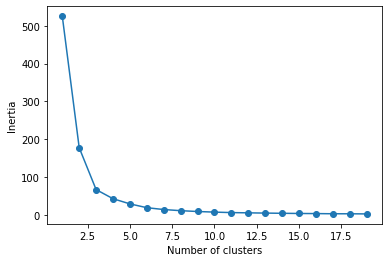

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


X = df_merged.loc[:, ['Education index', 'Log Tax per Capita']]


# Testing the intertia when using differnt number of clusters, between 1 and 20 clusters.
SSE = []
for cluster in range(1, 20):
    kmeans = KMeans(n_clusters=cluster, init='k-means++')
    kmeans.fit(X)
    SSE.append(kmeans.inertia_)

# Converts results to a dataframe and plotting
frame = pd.DataFrame({'Cluster': range(1, 20), 'SSE': SSE})
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')


# From the elbow plot optimal number of clusters is betwwen 3 and 5.

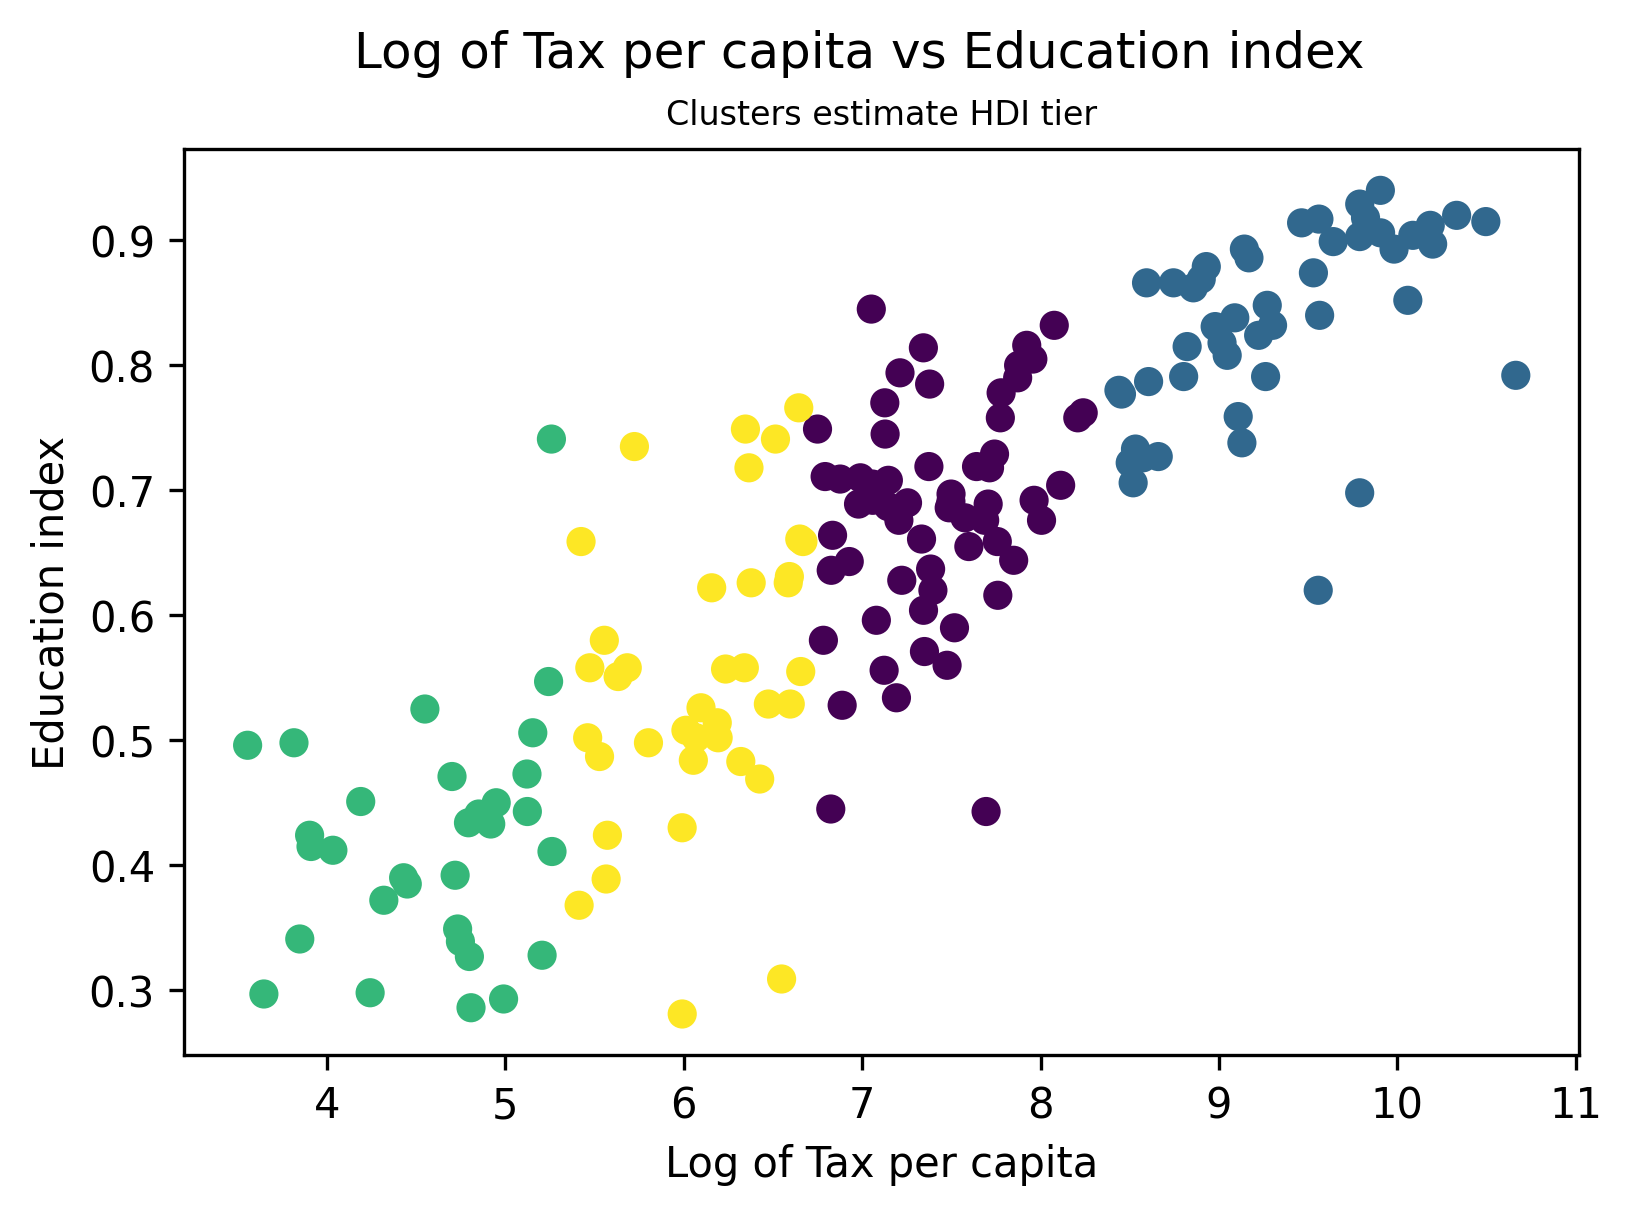

In [ ]:
plt.rcParams['figure.dpi'] = 300


# Perform k-means clustering
kmeans = KMeans(n_clusters = 4,  random_state=0)
kmeans.fit(X)

# Predict the cluster labels for each data point
labels = kmeans.predict(X)

# Plot the data points, coloring them based on their cluster label
plt.scatter(X['Log Tax per Capita'], X['Education index'],
            c=labels, cmap='viridis')


# Show the plot

plt.suptitle('Log of Tax per capita vs Education index', fontsize=12)
plt.title('Clusters estimate HDI tier', fontsize=8)
plt.xlabel('Log of Tax per capita')
plt.ylabel('Education index')
plt.show()

In [ ]:
df_merged['Cluster'] = pd.Series(labels, index=df_merged.index)

In [ ]:
# Assigning categories bsaed on cluster numbers ranking


def label_category(row):
    if row['Cluster'] == 1 :
        return 'very high'
    elif row['Cluster'] == 0:
        return 'high'
    elif row['Cluster'] == 3 :
        return 'medium'
    elif row['Cluster'] == 2 :
        return 'low'


df_merged['Cluster prediction'] = df_merged.apply(label_category, axis=1)

df_merged.head(10)


,Life expectancy,Country code,Education index,Country,Population,GDP,GDP per capita,Total tax revenue,Government spending,Spending per Capita,Tax per Capita,HDI,Category,Log Tax per Capita,Cluster,Cluster prediction
0,85.03,JPN,0.848,Japan,125681593.0,4.932556e+12,39246.0,1.334944e+12,1.609710e+12,12807.842116,10621.634944,0.925,very high,9.270648,1,very high
1,84.25,CHE,0.897,Switzerland,8736510.0,7.997960e+11,91546.0,2.344450e+11,2.642320e+11,30244.571345,26835.086322,0.962,very high,10.197466,1,very high
2,84.07,SGP,0.832,Singapore,5454000.0,3.969920e+11,72795.0,5.967800e+10,9.603100e+10,17607.444078,10942.060873,0.939,very high,9.300369,1,very high
3,84.01,ITA,0.791,Italy,58983122.0,2.101275e+12,35625.0,6.207390e+11,9.407710e+11,15949.833920,10524.010581,0.895,very high,9.261415,1,very high
4,83.99,ESP,0.824,Spain,47615034.0,1.426224e+12,30090.0,4.819450e+11,6.577500e+11,13813.914320,10121.698117,0.905,very high,9.222437,1,very high
5,83.94,AUS,0.929,Australia,25767000.0,1.635255e+12,63464.0,4.595460e+11,5.938560e+11,23047.153336,17834.672255,0.951,very high,9.788900,1,very high
6,83.52,ISL,0.912,Iceland,376248.0,2.545900e+10,67665.0,9.962000e+09,9.735000e+09,25873.891688,26477.217155,0.959,very high,10.184040,1,very high
7,83.50,KOR,0.862,South Korea,51736000.0,1.797810e+12,34744.0,3.631200e+11,4.144520e+11,8010.901500,7018.710376,0.925,very high,8.856335,1,very high
8,83.49,ISR,0.874,Israel,9367000.0,4.885270e+11,52152.0,1.288650e+11,1.784650e+11,19052.524821,13757.339596,0.919,very high,9.529328,1,very high
9,83.33,SWE,0.904,Sweden,10452326.0,6.356640e+11,60816.0,2.510090e+11,2.822230e+11,27000.975668,24014.654729,0.947,very high,10.086420,1,very high


In [ ]:
#Comparing the prediction to the correct tier
Actual = df_merged['Category']
Prediction = df_merged['Cluster prediction']


match = Actual.eq(Prediction)

# Calculate the percentage of values that match
percent_match = match.mean()

print(f'Percentage of values that match: {percent_match*100:.0f}%')


Percentage of values that match: 72%
